## Problem

In [1]:
# Setup
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import trange

%matplotlib inline
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set random seed for reproducibility
seed = 1234
# cuDNN uses nondeterministic algorithms, set some options for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)

In [2]:
# Initial transform (convert to PyTorch Tensor only)
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

## Use the following lines to check the basic statistics of this dataset
# Calculate training data mean and standard deviation to apply normalization to data
# train_data.data are of type uint8 (range 0,255) so divide by 255.
# train_mean = train_data.data.double().mean() / 255.
# train_std = train_data.data.double().std() / 255.
# print(f'Train Data: Mean={train_mean}, Std={train_std}')

## Optional: Perform normalization of train and test data using calculated training mean and standard deviation
# This will convert data to be approximately standard normal
#transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize((train_mean, ), (train_std, ))
#])

train_data.transform = transform
test_data.transform = transform

batch_size = 64
torch.manual_seed(seed)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=True) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=True)

Images shape:  torch.Size([64, 1, 28, 28])
Labels shape:  torch.Size([64])
Mean=0.1332315057516098, Std=0.3099796175956726


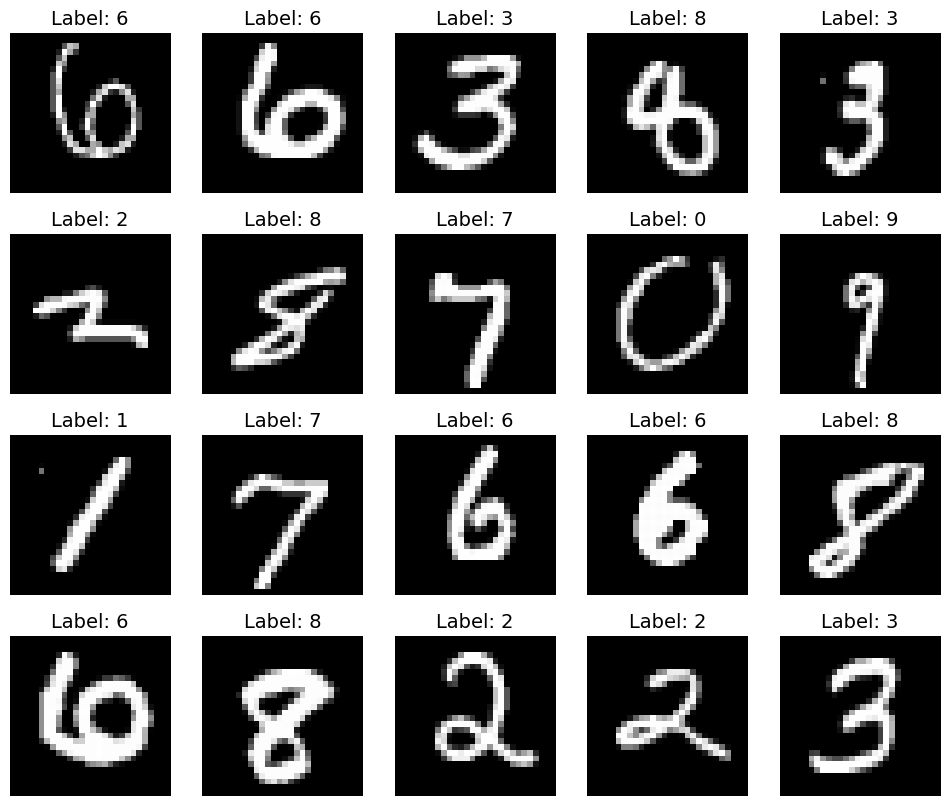

In [3]:
# Randomly sample 20 images of the training dataset
for images, labels in train_loader:
    break 

# Print information and statistics of the first batch of images
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)
print(f'Mean={images.mean()}, Std={images.std()}')

fig = plt.figure(figsize=(12, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray', interpolation='none')
    plt.title(f'Label: {labels[i]}', fontsize=14)
    plt.axis('off')
plt.show()

### Part 1: Implement a two-layer neural network

Write a class that constructs a two-layer neural network. The class consists of two methods, an initialization that sets up the architecture of the model, and a forward pass function given an input feature.

In [4]:
input_size = 1 * 28 * 28  # input spatial dimension of images
hidden_size = 128         # width of hidden layer
output_size = 10          # number of output neurons

class MNISTClassifierMLP(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten(start_dim=1)
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.act = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        y_output = self.log_softmax(x)
        return y_output

model = MNISTClassifierMLP().to(DEVICE)

# sanity check
# print(model)

### Part 2: Implement an optimizer to train the neural net model
Write a method called train_one_epoch that runs one step using the optimizer.

In [5]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []
    
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)

        optimizer.zero_grad()  
        output = model(img)   
        loss = torch.nn.functional.nll_loss(output, label)  
        loss.backward()        
        optimizer.step()       
    
        # Record training loss every log_interval and keep counter of total training images seen
        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))

    return losses, counter

### Part 3: Run the optimization procedure and test the trained model

Write a method called `test_one_epoch` that evalutes the trained model on the test dataset. Return the average test loss and the number of samples that the model predicts correctly.

In [6]:
def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)
            
            output = model(img)
            pred = output.argmax(dim=1, keepdim=True) 
            num_correct += pred.eq(label.view_as(pred)).sum().item()
            test_loss += torch.nn.functional.nll_loss(output, label, reduction='sum').item()
            
    test_loss /= len(test_loader.dataset)
    return test_loss, num_correct

Train the model using the cell below. Hyperparameters are given.

In [7]:
# Hyperparameters
lr = 0.01
max_epochs=10
gamma = 0.95

# Recording data
log_interval = 100

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses = []
train_counter = []
test_losses = []
test_correct = []
for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, counter = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
    test_loss, num_correct = test_one_epoch(test_loader, model, DEVICE)

    # Record results
    train_losses.extend(train_loss)
    train_counter.extend(counter)
    test_losses.append(test_loss)
    test_correct.append(num_correct)

print(f"Test accuracy: {test_correct[-1]/len(test_loader.dataset)}")

Epochs: 100%|███████████████████████████████████| 10/10 [00:53<00:00,  5.34s/it]

Test accuracy: 0.9311


### Part 4: Inspection

**1. Plot the loss curve as the number of epochs increases.**

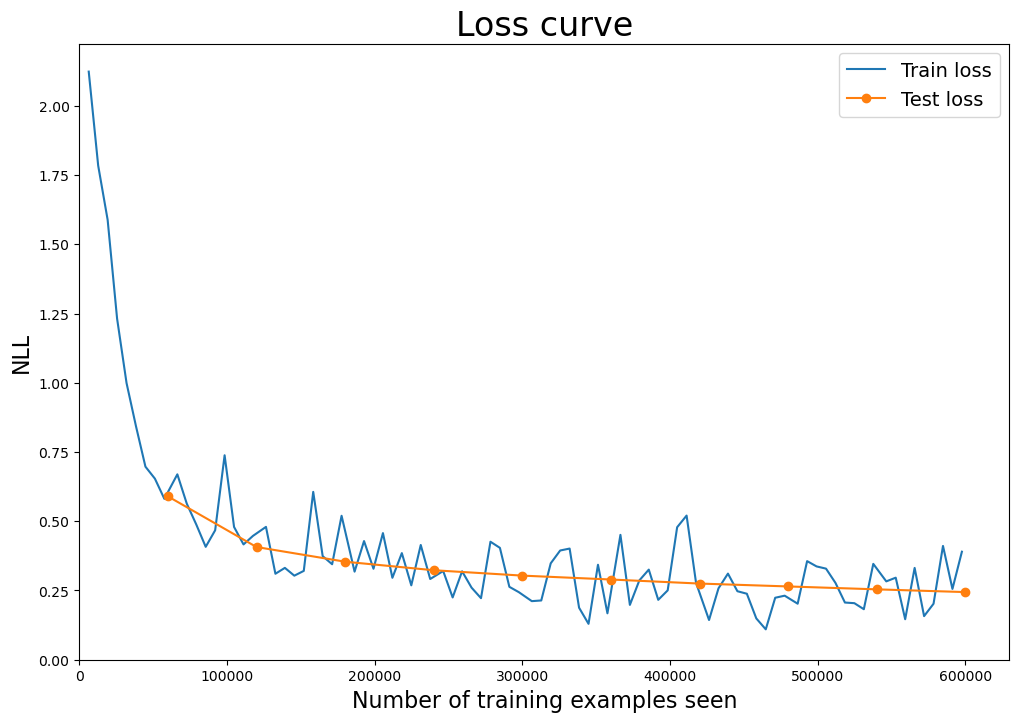

In [8]:
fig = plt.figure(figsize=(12,8))
plt.plot(train_counter, train_losses, label='Train loss')
plt.plot([i * len(train_loader.dataset) for i in range(1, max_epochs + 1)], 
         test_losses, label='Test loss', marker='o')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title('Loss curve', fontsize=24)
plt.xlabel('Number of training examples seen', fontsize=16)
plt.ylabel('NLL', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

**2. Show the predictions of the first 20 images of the test set.**

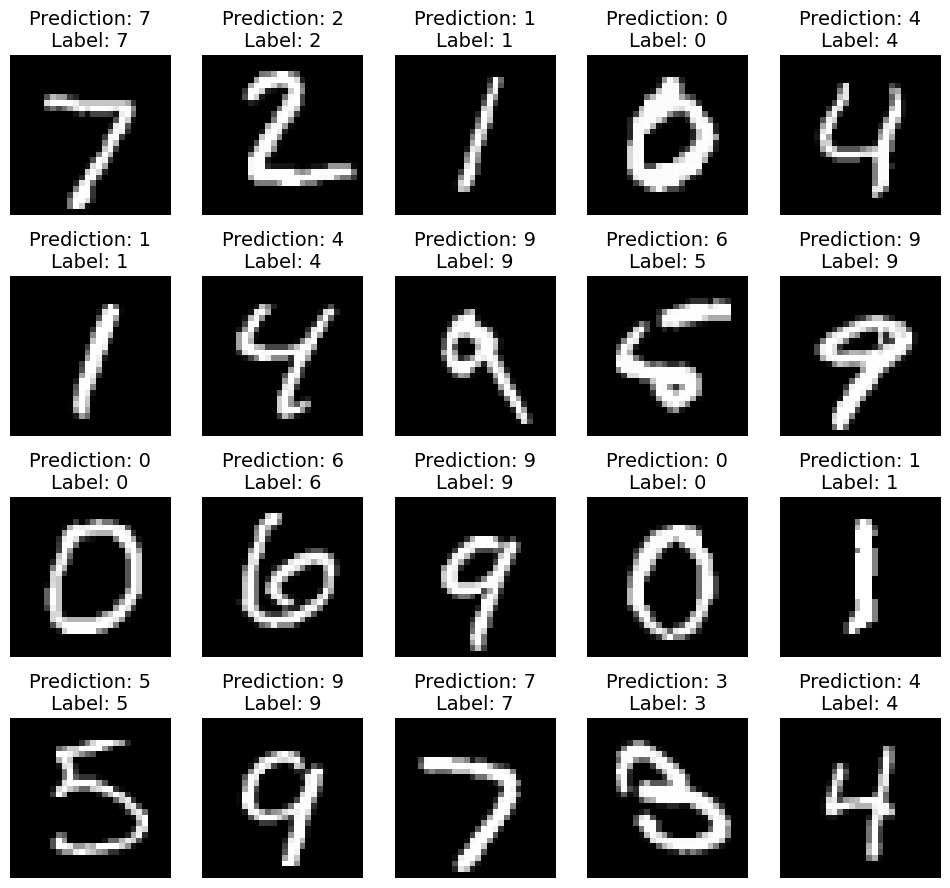

In [9]:
for images, labels in test_loader:
    break 
    
images, labels = images.to(DEVICE), labels.to(DEVICE)

output = model(images)
pred = output.argmax(dim=1)

fig = plt.figure(figsize=(12, 11))

for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].squeeze().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title(f'Prediction: {pred[i].item()}\nLabel: {labels[i].item()}', fontsize=14)
    plt.axis('off')

**3. Show the first 20 images that the model predicted incorrectly. Discuss about some of the common scenarios that the model predicted incorrectly.**

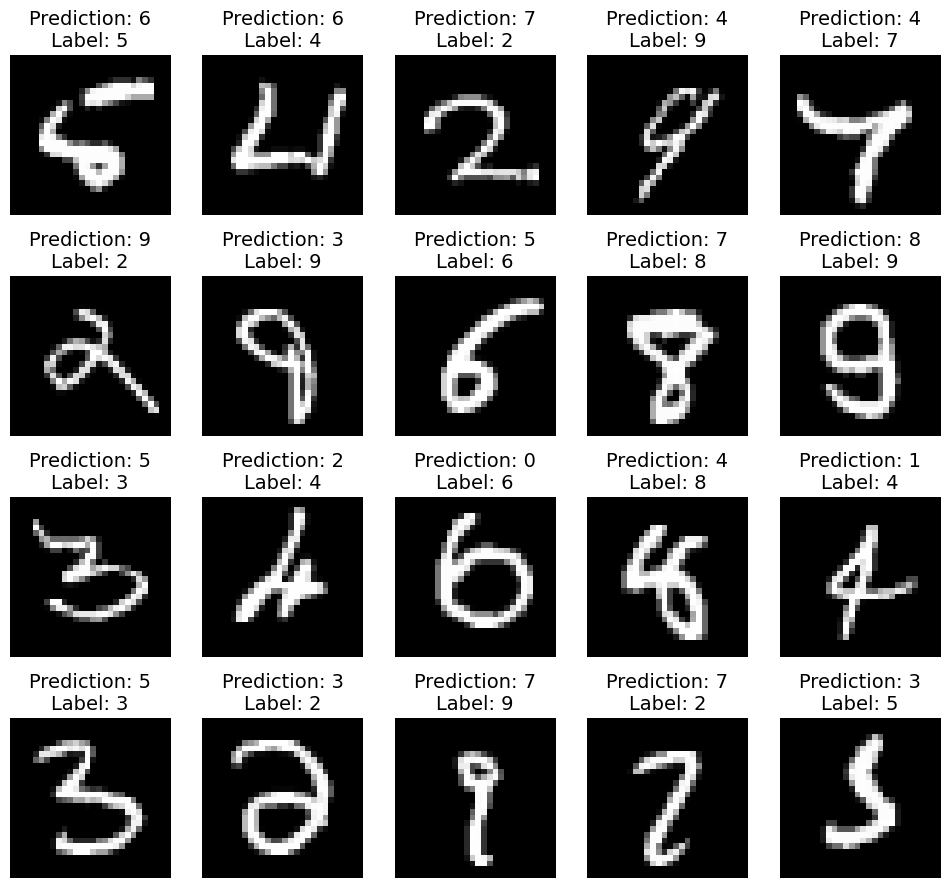

In [10]:
# 3. Get 20 incorrect predictions in test dataset

# Collect the images, predictions, labels for the first 20 incorrect predictions
# Initialize empty tensors and then keep appending to the tensor.
# Make sure that the first dimension of the tensors is the total number of incorrect
# predictions seen so far
# Ex) incorrect_imgs should be of shape i x C x H x W, where i is the total number of 
# incorrect images so far.
incorrect_imgs = torch.Tensor().to(DEVICE)
incorrect_preds = torch.IntTensor().to(DEVICE)
incorrect_labels = torch.IntTensor().to(DEVICE)

with torch.no_grad():
    # Test set iterator
    it = iter(test_loader)
    # Loop over the test set batches until incorrect_imgs.size(0) >= 20
    while incorrect_imgs.size(0) < 20:
        for images, labels in it:
            break 
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        output = model(images)
        pred = output.argmax(dim=1)

        incorrect_mask = pred.eq(labels.view_as(pred)) == 0
        incorrect_imgs = torch.cat([incorrect_imgs, images[incorrect_mask]])
        incorrect_preds = torch.cat([incorrect_preds, pred[incorrect_mask]])
        incorrect_labels = torch.cat([incorrect_labels, labels[incorrect_mask]])
                
# Show the first 20 wrong predictions in test set
fig = plt.figure(figsize=(12, 11))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(incorrect_imgs[i].squeeze().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title(f'Prediction: {incorrect_preds[i].item()}\nLabel: {incorrect_labels[i].item()}', fontsize=14)
    plt.axis('off')

**4. The result after this normalization step again.**

In [11]:
# Initial transform (convert to PyTorch Tensor only)
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

## Use the following lines to check the basic statistics of this dataset
# Calculate training data mean and standard deviation to apply normalization to data
# train_data.data are of type uint8 (range 0,255) so divide by 255.
train_mean = train_data.data.double().mean() / 255.
train_std = train_data.data.double().std() / 255.
print(f'Train Data: Mean={train_mean}, Std={train_std}')

## Optional: Perform normalization of train and test data using calculated training mean and standard deviation
# This will convert data to be approximately standard normal
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((train_mean, ), (train_std, ))
])

train_data.transform = transform
test_data.transform = transform

batch_size = 64
torch.manual_seed(seed)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=True) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=True)

Train Data: Mean=0.1306604762738429, Std=0.3081078071231272


### Part 0

Images shape:  torch.Size([64, 1, 28, 28])
Labels shape:  torch.Size([64])
Mean=0.008344569243490696, Std=1.0060752630233765


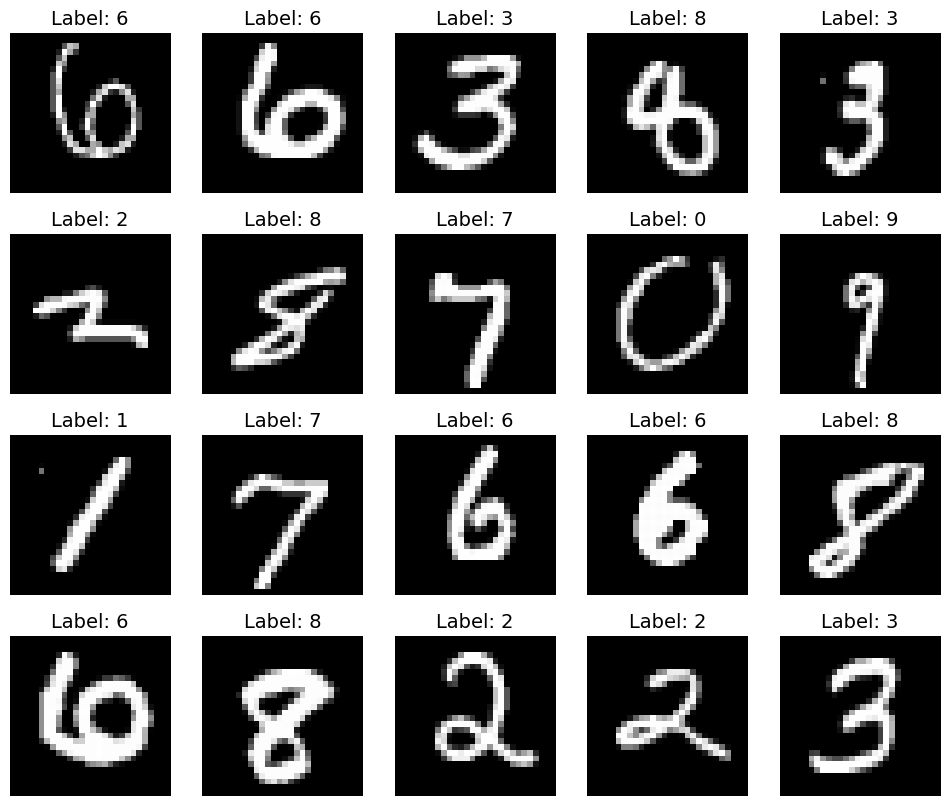

In [12]:
# Randomly sample 20 images of the training dataset
for images, labels in train_loader:
    break 

# Print information and statistics of the first batch of images
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)
print(f'Mean={images.mean()}, Std={images.std()}')

fig = plt.figure(figsize=(12, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray', interpolation='none')
    plt.title(f'Label: {labels[i]}', fontsize=14)
    plt.axis('off')
plt.show()

In [16]:
# Hyperparameters
lr = 0.01
max_epochs=10
gamma = 0.95

# Recording data
log_interval = 100

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses = []
train_counter = []
test_losses = []
test_correct = []
for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, counter = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
    test_loss, num_correct = test_one_epoch(test_loader, model, DEVICE)

    # Record results
    train_losses.extend(train_loss)
    train_counter.extend(counter)
    test_losses.append(test_loss)
    test_correct.append(num_correct)

print(f"Test accuracy: {test_correct[-1]/len(test_loader.dataset)}")

Epochs: 100%|███████████████████████████████████| 10/10 [01:09<00:00,  6.92s/it]

Test accuracy: 0.9636


### Part 4

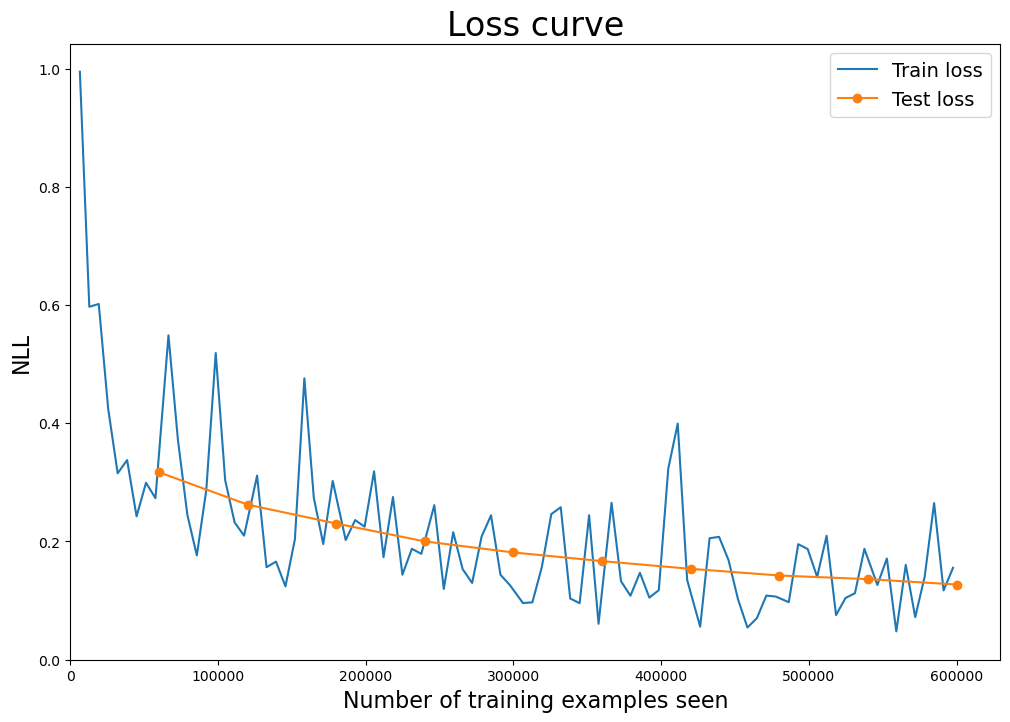

In [17]:
# 1.
fig = plt.figure(figsize=(12,8))
plt.plot(train_counter, train_losses, label='Train loss')
plt.plot([i * len(train_loader.dataset) for i in range(1, max_epochs + 1)], 
         test_losses, label='Test loss', marker='o')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title('Loss curve', fontsize=24)
plt.xlabel('Number of training examples seen', fontsize=16)
plt.ylabel('NLL', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

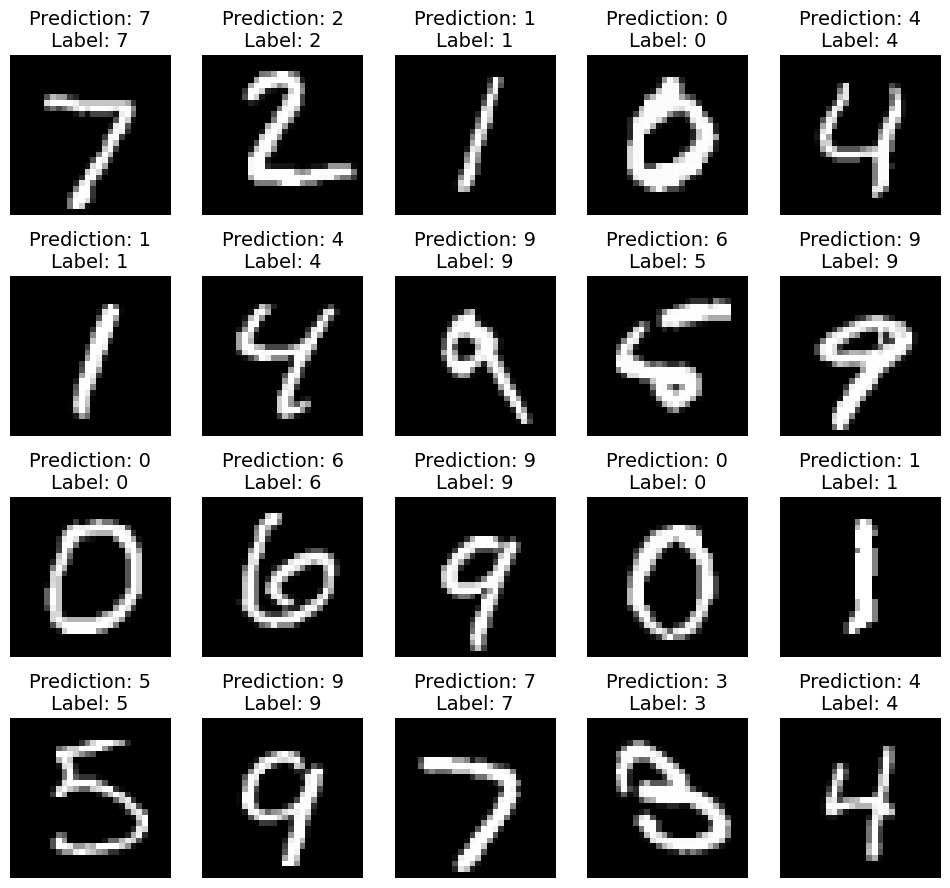

In [18]:
#2. 
for images, labels in test_loader:
    break 
    
images, labels = images.to(DEVICE), labels.to(DEVICE)

output = model(images)
pred = output.argmax(dim=1)

fig = plt.figure(figsize=(12, 11))

for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].squeeze().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title(f'Prediction: {pred[i].item()}\nLabel: {labels[i].item()}', fontsize=14)
    plt.axis('off')

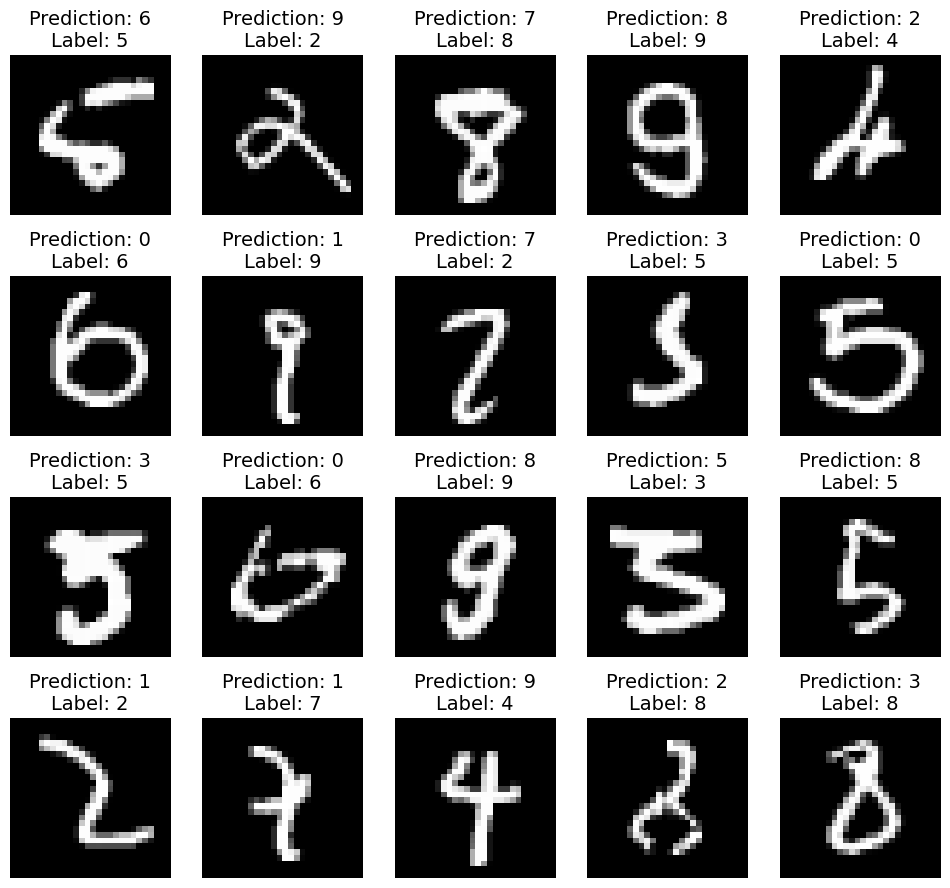

In [19]:
#3.
# 3. Get 20 incorrect predictions in test dataset

# Collect the images, predictions, labels for the first 20 incorrect predictions
# Initialize empty tensors and then keep appending to the tensor.
# Make sure that the first dimension of the tensors is the total number of incorrect
# predictions seen so far
# Ex) incorrect_imgs should be of shape i x C x H x W, where i is the total number of 
# incorrect images so far.
incorrect_imgs = torch.Tensor().to(DEVICE)
incorrect_preds = torch.IntTensor().to(DEVICE)
incorrect_labels = torch.IntTensor().to(DEVICE)

with torch.no_grad():
    # Test set iterator
    it = iter(test_loader)
    # Loop over the test set batches until incorrect_imgs.size(0) >= 20
    while incorrect_imgs.size(0) < 20:
        for images, labels in it:
            break 
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        output = model(images)
        pred = output.argmax(dim=1)

        incorrect_mask = pred.eq(labels.view_as(pred)) == 0
        incorrect_imgs = torch.cat([incorrect_imgs, images[incorrect_mask]])
        incorrect_preds = torch.cat([incorrect_preds, pred[incorrect_mask]])
        incorrect_labels = torch.cat([incorrect_labels, labels[incorrect_mask]])
                
# Show the first 20 wrong predictions in test set
fig = plt.figure(figsize=(12, 11))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(incorrect_imgs[i].squeeze().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title(f'Prediction: {incorrect_preds[i].item()}\nLabel: {incorrect_labels[i].item()}', fontsize=14)
    plt.axis('off')

## Problem

In [20]:
# Setup
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import trange
import torch.nn as nn

%matplotlib inline
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set random seed for reproducibility
seed = 1234
# cuDNN uses nondeterministic algorithms, set some options for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)

In [21]:
# Initial transform (convert to PyTorch Tensor only)
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

## Use the following lines to check the basic statistics of this dataset
# Calculate training data mean and standard deviation to apply normalization to data
# train_data.data are of type uint8 (range 0,255) so divide by 255.
# train_mean = train_data.data.double().mean() / 255.
# train_std = train_data.data.double().std() / 255.
# print(f'Train Data: Mean={train_mean}, Std={train_std}')

## Optional: Perform normalization of train and test data using calculated training mean and standard deviation
# This will convert data to be approximately standard normal
#transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize((train_mean, ), (train_std, ))
#])

train_data.transform = transform
test_data.transform = transform

batch_size = 64
torch.manual_seed(seed)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=True) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=True)

Images shape:  torch.Size([64, 1, 28, 28])
Labels shape:  torch.Size([64])
Mean=0.1332315057516098, Std=0.3099796175956726


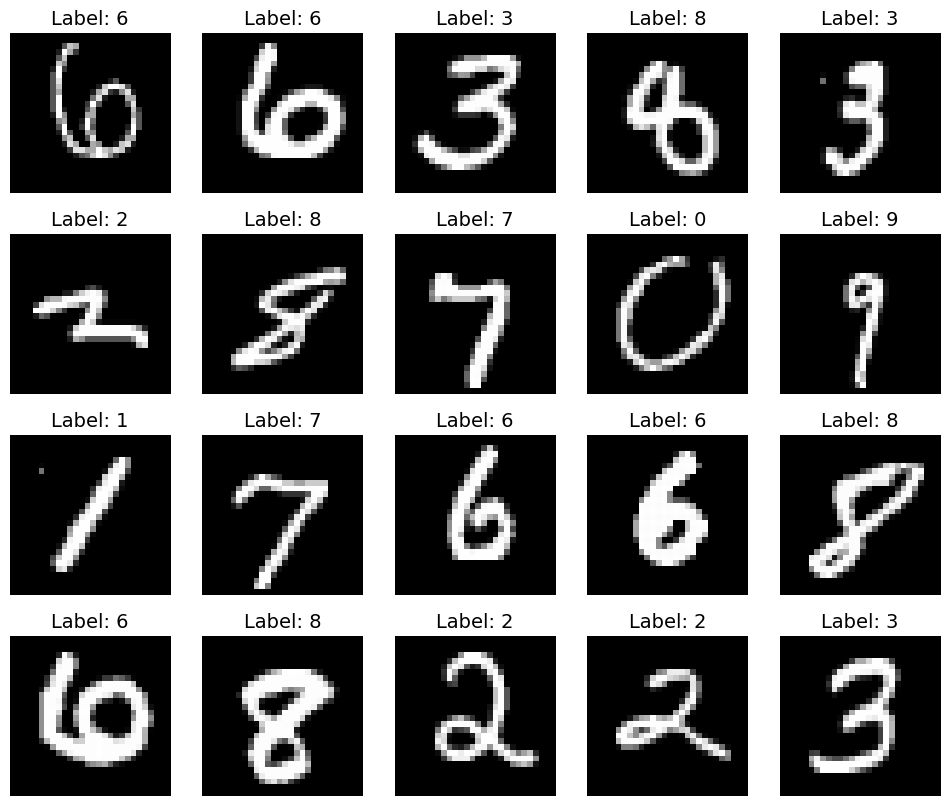

In [22]:
# Randomly sample 20 images of the training dataset
for images, labels in train_loader:
    break 

# Print information and statistics of the first batch of images
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)
print(f'Mean={images.mean()}, Std={images.std()}')

fig = plt.figure(figsize=(12, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray', interpolation='none')
    plt.title(f'Label: {labels[i]}', fontsize=14)
    plt.axis('off')
plt.show()

### Part 1: Implement a convolutional neural network

Write a class that constructs a two-layer neural network as specified in the handout. The class consists of two methods, an initialization that sets up the architecture of the model, and a forward pass function given an input feature.

In [23]:
input_size = 1 * 28 * 28  # input spatial dimension of images
hidden_size = 128         # width of hidden layer
output_size = 10          # number of output neurons

class CNN(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()

        self.flatten = nn.Flatten(start_dim=1)
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc = nn.Linear(320, hidden_size)
        self.relu3 = nn.ReLU()

        self.output = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.flatten(x)
        
        x = self.fc(x)
        x = self.relu3(x)

        y_output = nn.functional.log_softmax(self.output(x), dim=1)
        
        return y_output

model = CNN().to(DEVICE)

# sanity check
# print(model)

Write a method called train_one_epoch that runs one step using the optimizer.

In [24]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []
    correct = 0
    total = 0
    
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)

        output = model(img)
        loss = torch.nn.functional.nll_loss(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        # Record training loss every log_interval and keep counter of total training images seen
        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))

    accuracy = correct / total
    return losses, counter, accuracy


Write a method called `test_one_epoch` that evalutes the trained model on the test dataset. Return the average test loss and the number of samples that the model predicts correctly.

In [25]:
def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)

            output = model(img)
            pred = output.argmax(dim=1, keepdim=True) 
            num_correct += pred.eq(label.view_as(pred)).sum().item()
            test_loss += torch.nn.functional.nll_loss(output, label).item()
            
    test_loss /= len(test_loader.dataset)
    return test_loss, num_correct

Train the model using the cell below. Hyperparameters are given.

In [26]:
# Hyperparameters
lr = 0.01
max_epochs=10
gamma = 0.95

# Recording data
log_interval = 100

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses = []
train_accuracies = []
train_counter = []
test_losses = []
test_correct = []

for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, counter, train_accuracy = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
    test_loss, num_correct = test_one_epoch(test_loader, model, DEVICE)

    # Record results
    train_losses.extend(train_loss)
    train_counter.extend(counter)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_correct.append(num_correct)
    
print(f"Test accuracy (CNN): {test_correct[-1]/len(test_loader.dataset)}")
print(f"Test Loss (CNN): {test_losses[-1]:.4f}")

print(f"Training Loss (CNN): {train_losses[-1]:.4f}")
print(f"Training Accuracy (CNN): {train_accuracies[-1]:.4f}")

Epochs: 100%|███████████████████████████████████| 10/10 [02:38<00:00, 15.88s/it]

Test accuracy: 0.98
Test Loss: 0.0010
Training Loss: 0.0848
Training Accuracy: 0.9797


### FNN Implementation

In [31]:
input_size = 1 * 28 * 28  # input spatial dimension of images
hidden_size = 128         # width of hidden layer
output_size = 10          # number of output neurons

class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, input_size)
        x = self.relu1(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

fnn_model = FNN().to(DEVICE)

In [32]:
# Hyperparameters
lr = 0.01
max_epochs=10
gamma = 0.95

# Recording data
log_interval = 100

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(fnn_model.parameters(), lr=lr)

train_losses = []
train_accuracies = []
train_counter = []
test_losses = []
test_correct = []

for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, counter, train_accuracy = train_one_epoch(train_loader, fnn_model, DEVICE, optimizer, log_interval, epoch)
    test_loss, num_correct = test_one_epoch(test_loader, fnn_model, DEVICE)

    # Record results
    train_losses.extend(train_loss)
    train_counter.extend(counter)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_correct.append(num_correct)
    
print(f"Test accuracy (FNN): {test_correct[-1]/len(test_loader.dataset)}")

Epochs: 100%|███████████████████████████████████| 10/10 [00:54<00:00,  5.45s/it]

Test accuracy (FNN): 0.6767


In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The CNN has {count_parameters(model)} parameters")
print(f"The FNN has {count_parameters(fnn_model)} parameters")

The CNN has 47658 parameters
The FNN has 101770 parameters


The performance of the two models on the MNIST dataset is as follows:

The Convolutional Neural Network (CNN) has a test accuracy of 0.98 and uses 47,658 parameters.
The Feedforward Neural Network (FNN) has a test accuracy of 0.6767 and uses 101,770 parameters.

In terms of performance, the CNN significantly outperforms the FNN, achieving a much higher test accuracy.

In terms of parameter efficiency, which can be defined as the test accuracy divided by the number of parameters, the CNN is also more efficient. Here’s how we calculate it:

For the CNN:

$ \text{Parameter Efficiency (CNN)} = \frac{\text{Test Accuracy (CNN)}}{\text{Number of Parameters (CNN)}} = \frac{0.98}{47,658} \approx 2.06 \times 10^{-5}$

For the FNN:

$ \text{Parameter Efficiency (FNN)} = \frac{\text{Test Accuracy (FNN)}}{\text{Number of Parameters (FNN)}} = \frac{0.6767}{101,770} \approx 6.65 \times 10^{-6} $


Therefore, for the MNIST dataset, the CNN is more parameter-efficient than the FNN. The reason for this is that CNNs work especially well with picture data, such as MNIST, where the spatial correlations between individual pixels are significant. Compared to a FNN, a CNN's convolutional layers are better at capturing these spatial correlations and require less parameters.

Thus, in this instance, the CNN outperforms the FNN in terms of accuracy and parameter efficiency.